In [1]:
import wandb
import pandas as pd
from loguru import logger
from tqdm import tqdm
from itertools import product
import numpy as np
from pathlib import Path
import functools
import json
from typing import Literal
import multiprocessing as mp
from tqdm.contrib.concurrent import process_map
import math

from histaug.utils import RunningStats, cached_df, savefig, rc_context
from histaug.utils.display import (
    RENAME_MODELS,
    RENAME_FEATURE_EXTRACTORS,
    RENAME_TARGETS,
    TARGET_GROUPS,
    RENAME_AUGMENTATION_GROUPS,
    RENAME_MAGNIFICATIONS,
)
from histaug.analysis.collect_results import load_aurocs

api = wandb.Api()

INDEX_COLS = [
    "magnification",
    "target",
    "train_dataset",
    "test_dataset",
    "model",
    "feature_extractor",
    "augmentations",
    "seed",
]

RESULTS_DIR = Path("/app/results")

# Collect results from `wandb`

In [2]:
df = df_all = load_aurocs().drop_duplicates().droplevel(["train_dataset", "test_dataset"])

df = (
    df.reset_index()
    .groupby(["magnification", "target", "model", "feature_extractor", "augmentations"])
    .filter(lambda x: sorted(x.seed.values) == list(range(5)))
    .set_index(df.index.names)
    .sort_index()
)
print("Removed runs:", len(df_all) - len(df))
print(
    df_all.index.difference(df.index)
    .to_frame(index=False)
    .groupby([x for x in df.index.names if x != "seed"])
    .seed.count()
)

2024-01-30 18:11:56.685 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading aurocs from cache


Removed runs: 0
Series([], Name: seed, dtype: int64)


In [3]:
def compute_overall_average(df):
    # Computer overall mean and std (across targets)
    targets = df.columns.get_level_values("target").unique()
    assert "average" not in targets
    n_targets = len(targets)
    overall_mean = df.stack().query("stats == 'mean'").droplevel("stats").sum(axis="columns").divide(n_targets)
    overall_std = (
        df.stack().query("stats == 'std'").droplevel("stats").pow(2).sum(axis="columns").divide(n_targets).pow(0.5)
    )
    df["average", "mean"] = overall_mean
    df["average", "std"] = overall_std
    return df


def results_to_latex(r, goal="min"):
    # Format for appearance
    r = r.unstack(["magnification", "model", "augmentations"])
    means = r.stack("stats").query("stats == 'mean'").droplevel("stats")
    stds = r.stack("stats").query("stats == 'std'").droplevel("stats")

    has_average = "average" in means.columns

    formatted = means.map(lambda x: f"{x:.2f}") + " \\pm " + stds.map(lambda x: f"{x:.2f}")

    # Make best model bold
    best_mask = means == getattr(means, goal)(axis="index")
    formatted[best_mask] = "\\mathbf{" + formatted[best_mask] + "}"
    formatted = "$" + formatted + "$"
    formatted = formatted.stack("model")
    formatted = formatted.swaplevel("feature_extractor", "model").sort_index()

    formatted = formatted.stack(["magnification", "augmentations"])

    # Set index order to augmentations, model, feature_extractor
    formatted = formatted.reorder_levels(["magnification", "augmentations", "model", "feature_extractor"]).reindex(
        [*RENAME_TARGETS.keys(), *(["average"] if has_average else [])], axis=1
    )

    def sort_df_index(df, keys):
        """Sort a dataframe by index level values.

        Args:
            df: Dataframe to sort.
            keys: dict of {level: order} where:
                level: Name of index level to sort by.
                order: List of values in the order you want them to appear in that level
        """

        return df.sort_index(key=lambda x: x.map({v: i for i, v in enumerate(keys[x.name])}) if x.name in keys else x)

    def rename_df(df):
        rename_levels = {
            "magnification": "Magnification",
            "feature_extractor": "Feature extractor",
            "model": "Model",
            "augmentations": "Augmentations",
            "target": "Target",
        }
        for axis in [0, 1]:
            d = df.index if axis == 0 else df.columns
            for level in d.names:
                if level == "feature_extractor":
                    df = df.rename(RENAME_FEATURE_EXTRACTORS, level=level, axis=axis)
                elif level == "model":
                    df = df.rename(RENAME_MODELS, level=level, axis=axis)
                elif level == "augmentations":
                    df = df.rename(RENAME_AUGMENTATION_GROUPS, level=level, axis=axis)
                elif level == "target":
                    df = df.rename(RENAME_TARGETS, level=level, axis=axis)
                elif level == "magnification":
                    df = df.rename(RENAME_MAGNIFICATIONS, level=level, axis=axis)

        df.index.set_names([rename_levels.get(x, x) for x in df.index.names], inplace=True)
        df.columns.set_names([rename_levels.get(x, x) for x in df.columns.names], inplace=True)
        return df

    formatted = sort_df_index(
        formatted,
        {
            "magnification": RENAME_MAGNIFICATIONS.keys(),
            "augmentations": RENAME_AUGMENTATION_GROUPS.keys(),
            "model": RENAME_MODELS.keys(),
            "feature_extractor": RENAME_FEATURE_EXTRACTORS.keys(),
        },
    )

    only_one_magnification = len(formatted.index.unique("magnification")) == 1
    if only_one_magnification:
        formatted = formatted.droplevel("magnification")

    only_one_augmentation = len(formatted.index.unique("augmentations")) == 1
    if only_one_augmentation:
        formatted = formatted.droplevel("augmentations")

    formatted = rename_df(formatted).rename(columns={"average": "Average"})

    col_format = (
        ("" if only_one_magnification else "l")
        + ("" if only_one_augmentation else "l")
        + "ll|"
        + "|".join(("c" * len(group) for group in TARGET_GROUPS.values()))
        + ("|c" if has_average else "")
    )
    return formatted.to_latex(escape=False, column_format=col_format, multicolumn_format="c")

## Total training time

In [4]:
gpu_hours = df.runtime.sum() / 60 / 60
print(f"Total GPU hours: {gpu_hours:.1f} ({gpu_hours / 24:.1f} days)")

Total GPU hours: 6997.4 (291.6 days)


## Show results

In [5]:
d = (
    df["test_auroc"]
    .groupby(["magnification", "augmentations", "model", "feature_extractor", "target"])
    .agg(["mean", "std"])
)
d.columns.name = "stats"
d = d.unstack("target").reorder_levels(["target", "stats"], axis=1).sort_index(axis=1)
# d = compute_overall_average(d)
d

target                                                              BRAF  \
stats                                                               mean   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                      NaN   
                                             ctranspath              NaN   
                                             dino_p16                NaN   
                                             mocov2                  NaN   
                                             owkin                   NaN   
...                                                                  ...   
low           simple_rotate     Transformer  retccl             0.588630   
                                             swav               0.698604   
                                             swin               0.559441   
                                             vit                0.611370   
                                             vits               0.588697   

target                                                                    \
stats                                                                std   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                      NaN   
                                             ctranspath              NaN   
                                             dino_p16                NaN   
                                             mocov2                  NaN   
                                             owkin                   NaN   
...                                                                  ...   
low           simple_rotate     Transformer  retccl             0.061571   
                                             swav               0.076306   
                                             swin               0.091344   
                                             vit                0.066482   
                                             vits               0.051542   

target                                                              CDH1  \
stats                                                               mean   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.652656   
                                             ctranspath         0.704055   
                                             dino_p16           0.742319   
                                             mocov2             0.654540   
                                             owkin              0.760594   
...                                                                  ...   
low           simple_rotate     Transformer  retccl             0.738378   
                                             swav               0.760708   
                                             swin               0.698458   
                                             vit                0.718275   
                                             vits               0.761508   

target                                                                    \
stats                                                                std   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.013032   
                                             ctranspath         0.047242   
                                             dino_p16           0.020883   
                                             mocov2             0.031060   
                                             owkin              0.034850   
...                                                                  ...   
low           simple_rotate     Transformer  retccl             0.044368   
                                             

In [6]:
TABLES_DIR = Path("/app/figures/tables")
TABLES_DIR.mkdir(exist_ok=True, parents=True)

for magnification in RENAME_MAGNIFICATIONS.keys():
    for augmentations in RENAME_AUGMENTATION_GROUPS.keys():
        subset = d.query(f"magnification == @magnification and augmentations == @augmentations")
        if len(subset) == 0:
            logger.debug(f"No data for {magnification=} {augmentations=}; skipping")
            continue
        latex = results_to_latex(subset, goal="max")
        outfile = TABLES_DIR / f"mean_auroc__mag_{magnification}__aug_{augmentations}.tex"
        outfile.write_text(latex)

2024-01-30 18:11:58.345 | DEBUG    | __main__:<module>:8 - No data for magnification='high' augmentations='Macenko_slidewise'; skipping
2024-01-30 18:11:58.351 | DEBUG    | __main__:<module>:8 - No data for magnification='high' augmentations='all'; skipping
2024-01-30 18:11:58.357 | DEBUG    | __main__:<module>:8 - No data for magnification='high' augmentations='simple_rotate'; skipping
2024-01-30 18:11:58.351 | DEBUG    | __main__:<module>:8 - No data for magnification='high' augmentations='all'; skipping
2024-01-30 18:11:58.357 | DEBUG    | __main__:<module>:8 - No data for magnification='high' augmentations='simple_rotate'; skipping


# What is the best feature extractor?

In [7]:
from histaug.analysis.collect_results import compute_results_table

r = (
    compute_results_table(
        df["test_auroc"], keep_fixed=("magnification", "augmentations", "model", "target"), vary="feature_extractor"
    )
    .stack("feature_extractor")
    .unstack("target")
    .swaplevel("target", "stats", axis=1)
    .sort_index(axis=1)
)
r

2024-01-30 18:11:58.370 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading norm_diff__feature_extractor__magnification_augmentations_model_target from cache


target                                                              BRAF  \
stats                                                               mean   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                      NaN   
                                             ctranspath              NaN   
                                             dino_p16                NaN   
                                             mocov2                  NaN   
                                             owkin                   NaN   
...                                                                  ...   
low           simple_rotate     Transformer  retccl             0.182094   
                                             swav               0.072121   
                                             swin               0.211283   
                                             vit                0.159355   
                                             vits               0.182028   

target                                                                    \
stats                                                                std   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                      NaN   
                                             ctranspath              NaN   
                                             dino_p16                NaN   
                                             mocov2                  NaN   
                                             owkin                   NaN   
...                                                                  ...   
low           simple_rotate     Transformer  retccl             0.064449   
                                             swav               0.070438   
                                             swin               0.088295   
                                             vit                0.068241   
                                             vits               0.056975   

target                                                              CDH1  \
stats                                                               mean   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.152329   
                                             ctranspath         0.100929   
                                             dino_p16           0.062666   
                                             mocov2             0.150444   
                                             owkin              0.044390   
...                                                                  ...   
low           simple_rotate     Transformer  retccl             0.076662   
                                             swav               0.054332   
                                             swin               0.116582   
                                             vit                0.096765   
                                             vits               0.053532   

target                                                                    \
stats                                                                std   
magnification augmentations     model        feature_extractor             
high          Macenko_patchwise AttentionMIL bt                 0.027866   
                                             ctranspath         0.049248   
                                             dino_p16           0.031428   
                                             mocov2             0.037582   
                                             owkin              0.036119   
...                                                                  ...   
low           simple_rotate     Transformer  retccl             0.049124   
                                             

In [8]:
r = compute_overall_average(r)

for magnification in RENAME_MAGNIFICATIONS.keys():
    for augmentations in RENAME_AUGMENTATION_GROUPS.keys():
        subset = r.query(f"magnification == @magnification and augmentations == @augmentations")
        if len(subset) == 0:
            logger.debug(f"No data for {magnification=} {augmentations=}; skipping")
            continue
        latex = results_to_latex(subset, goal="min")
        outfile = TABLES_DIR / f"norm_diff_auroc__mag_{magnification}__aug_{augmentations}.tex"
        outfile.write_text(latex)

2024-01-30 18:11:59.635 | DEBUG    | __main__:<module>:7 - No data for magnification='high' augmentations='Macenko_slidewise'; skipping
2024-01-30 18:11:59.641 | DEBUG    | __main__:<module>:7 - No data for magnification='high' augmentations='all'; skipping
2024-01-30 18:11:59.648 | DEBUG    | __main__:<module>:7 - No data for magnification='high' augmentations='simple_rotate'; skipping
2024-01-30 18:11:59.641 | DEBUG    | __main__:<module>:7 - No data for magnification='high' augmentations='all'; skipping
2024-01-30 18:11:59.648 | DEBUG    | __main__:<module>:7 - No data for magnification='high' augmentations='simple_rotate'; skipping


# What is the best downstream aggregation model?

2024-01-30 18:12:00.155 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading norm_diff__model__magnification_augmentations_feature_extractor_target from cache


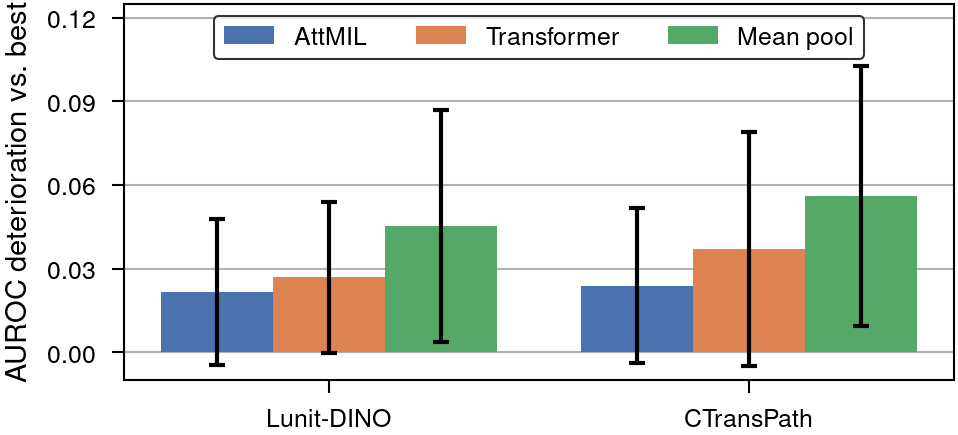

In [9]:
from histaug.analysis.collect_results import compute_results_table
import matplotlib.pyplot as plt
import seaborn as sns

magnification = "low"
augmentations = "none"
feature_extractors = RENAME_FEATURE_EXTRACTORS.keys()
feature_extractors = ["dino_p16", "ctranspath"]

r = compute_results_table(
    df["test_auroc"], keep_fixed=("magnification", "augmentations", "feature_extractor", "target"), vary="model"
)
r = r.query(
    "magnification == @magnification and augmentations == @augmentations and feature_extractor in @feature_extractors"
).droplevel(["magnification", "augmentations"])
r = r.stack("model").unstack("target").swaplevel("stats", "target", axis=1).sort_index(axis=1)
r = compute_overall_average(r)
r = r["average"]


with rc_context("half", h=0.75):
    group_width = 0.8
    bar_width = group_width / len(RENAME_MODELS)
    for i, (model, model_name) in enumerate(RENAME_MODELS.items()):
        s = r[r.index.get_level_values("model") == model].droplevel("model")
        s = s.reindex(feature_extractors)
        means = s["mean"]
        stds = s["std"]
        plt.bar(
            np.arange(len(means)) + i * bar_width - bar_width * (len(RENAME_MODELS) - 1) / 2,
            means,
            yerr=stds,
            width=bar_width,
            label=model_name,
            capsize=2,
            color=sns.color_palette("deep")[i],
        )
    plt.xticks(np.arange(len(feature_extractors)), [RENAME_FEATURE_EXTRACTORS[x] for x in feature_extractors])
    plt.legend(ncol=3, loc="upper center")
    plt.ylim(-0.01, 0.125)
    plt.xlabel("Feature extractor")
    plt.xlabel("")
    # plt.ylabel("Norm.\ diff.\ AUROC")
    plt.ylabel("AUROC deterioration vs.\ best")
    # decrease ylabel font size
    plt.gca().yaxis.label.set_size(7)
    # plt.xticks(rotation=45, ha="right")

    # horizontal grid
    plt.grid(axis="y")
    plt.yticks(np.arange(0.0, 0.13, 0.03))

    savefig(f"aggregation_comparison_aug_{augmentations}")
    plt.show()

# Compare magnifications

In [30]:
r = (
    df["test_auroc"]
    .unstack("seed")
    .query(
        "model == 'AttentionMIL' and augmentations in ['none', 'Macenko_patchwise'] and target in ['subtype', 'CDH1', 'PIK3CA', 'TP53']"
    )
)
r = r.droplevel("model")
r = r.query("augmentations == 'none'").droplevel("augmentations")
hi = r.query("magnification == 'high'").droplevel("magnification")
lo = r.query("magnification == 'low'").droplevel("magnification")
hi = hi.reindex(lo.index)
mean = hi.mean(axis="columns") - lo.mean(axis="columns")
std = (hi.std(axis="columns").pow(2) + lo.std(axis="columns").pow(2)).pow(0.5)
data = pd.concat([mean, std], axis=1, keys=["mean", "std"])

data

mean       std
target  feature_extractor                    
CDH1    bt                -0.084980  0.039134
        ctranspath        -0.102284  0.055917
        dino_p16          -0.077099  0.056740
        mocov2            -0.071959  0.026502
        owkin              0.051285  0.039942
        owkin_teacher      0.078127  0.058166
        resnet50          -0.051057  0.067777
        retccl            -0.061108  0.022507
        swav              -0.063621  0.030303
        swin               0.127870  0.062627
        vit                0.065220  0.023742
        vits               0.053341  0.032269
PIK3CA  bt                -0.041914  0.027114
        ctranspath        -0.003971  0.029293
        dino_p16          -0.020429  0.042353
        mocov2             0.037457  0.022259
        owkin              0.034200  0.054130
        owkin_teacher     -0.000857  0.050119
        resnet50           0.009343  0.061687
        retccl            -0.099743  0.051017
        swav               0.046343  0.076328
        swin               0.000686  0.028206
        vit                0.019200  0.049030
        vits               0.012657  0.051515
TP53    bt                -0.119024  0.132881
        ctranspath        -0.001291  0.036885
        dino_p16           0.001150  0.032080
        mocov2            -0.022250  0.022192
        owkin              0.039899  0.053974
        owkin_teacher      0.029854  0.064445
        resnet50          -0.042368  0.054236
        retccl            -0.088300  0.046027
        swav              -0.007912  0.043394
        swin               0.089955  0.057555
        vit                0.033586  0.047632
        vits              -0.037823  0.094094
subtype bt                -0.043426  0.048745
        ctranspath        -0.007393  0.024751
        dino_p16           0.018807  0.026588
        mocov2             0.020303  0.044900
        owkin              0.045093  0.011461
        owkin_teacher      0.031578  0.023527
        resnet50          -0.027641  0.040112
        retccl            -0.025351  0.029792
        swav              -0.047935  0.012079
        swin              -0.058330  0.014673
        vit               -0.050991  0.047139
        vits              -0.004507  0.027371